In [27]:
from __future__ import division
%matplotlib inline
import csv
import sys
import os
import traceback
import json
import pickle
import learn_utils
import meta_features as mf
import numpy as np
import pandas as pd
import scipy.io as sio
from scipy.signal import butter, lfilter, filtfilt
from tabulate import tabulate
from matplotlib import pyplot as plt
from collections import defaultdict, Counter
from detect_peaks import detect_peaks
from gaussian_kde import gaussian_kde
from sklearn.neighbors import KernelDensity
from operator import itemgetter

import scipy.signal as signal
import matplotlib.pyplot as plt

from helper_functions import getListOfFiles, getCSV, getStatistics, remap_interval

## Loading files names

In [28]:
def loadFile(file_name, directory, verbose=False):
    ##NOTE: IF "TOO MANY VALUES TO UNPACK" ERROR IN THE getCSV METHOD, RESTART THE KERNEL. SOMETHING MUST BE WRONG WITH
    # THE KERNEL INITIALIZATION. MUST BE CHECKED! (LOW-PRIORITY)

    csv_data = None          # the variable where the loaded csv data is stored.
    num_windows = 0          # the number of windows loaded.
    windows = []             # the list of windows data. Each element is a pandas dataframe 
                             #  corresponding to the windows. The list is of size 'num_windows'.

    ignore_col_list = ['/ext_usb_camera/image/compressed', 'robogame/imu_state']
    
    #print '-- Processing: "{}"'.format(file_name)

    # load the data, abort in case of error.
    try:
        num_windows, csv_data = getCSV(os.path.join(directory, file_name))
    except ValueError as e:
        print traceback.format_exc()
        sys.exit(-1)

    for w in range(num_windows):
        win_data = {}
        for k in csv_data.keys():
            # consider the data only if it is not in the ignore list.
            if k not in ignore_col_list:
                if  csv_data[k][w] == []:
                    raise ValueError("\tFile has empty tagged windows. Skipping...")
                win_data[feature_name_map[k]] = csv_data[k][w]
                
        # convert dictionary to dataframe and save it to list of all windows data for the file.
        windows.append(pd.DataFrame.from_dict(win_data))
    
    #print '-- Retrieved {} windows in {}'.format(num_windows, file_name)
    
    if verbose:
        overlap_reference = 50
        try:
            _, n_windows, sample_info, avg_overlap, avg_diff = getStatistics(csv_data, compareWith=overlap_reference)
            print "LOAD SUMMARY:"
            print tabulate([[n_windows,"{:.2f}".format(avg_overlap),"{:.2f}".format(avg_diff)]],
                               headers=["#Win", "Avg. Overlap", "Avg. dev. from ref."])
        except ValueError as e:
            print traceback.format_exc()
            return None
    return windows

In [29]:
csv_dir = "../data/annotated_csv/"
files = getListOfFiles(csv_dir, ".csv")
print ">> {} CSV Files found:\n".format(len(files))
print json.dumps(files)

>> 34 CSV Files found:

["_2016-11-23-18-49-13_exp1_Player.csv", "_2016-11-23-18-49-13_exp2_Player.csv", "_2016-11-23-18-49-13_exp3_Player.csv", "_2016-11-23-18-49-13_exp4_Player.csv", "_2016-11-23-18-49-13_exp5_Player.csv", "_2016-11-24-15-43-37_exp1d_Player.csv", "_2016-11-24-15-43-37_exp2d_Player.csv", "_2016-11-24-15-43-37_exp3d_Player.csv", "_2016-11-24-15-43-37_exp4d_Player.csv", "_2016-11-24-15-43-37_exp5d_Player.csv", "_2016-11-24-15-43-37_exp6d_Player.csv", "_2016-11-24-16-23-29_expa_Player.csv", "_2016-11-24-16-23-29_expb_Player.csv", "_2016-11-24-16-23-29_expc_Player.csv", "_2016-11-24-16-23-29_expd_Player.csv", "_2016-11-24-16-48-48_exp1d_Player.csv", "_2016-11-24-16-48-48_exp2d_Player.csv", "_2016-11-24-16-48-48_exp3d_Player.csv", "_2016-11-24-17-15-38_expa_Player.csv", "_2016-11-24-17-15-38_expb_Player.csv", "_2016-11-24-17-15-38_expc_Player.csv", "_2016-11-24-17-40-06_expb_Player.csv", "_2016-11-26-15-42-51_exp1d_Player.csv", "_2016-11-26-16-05-47_exp1d_Player.csv", "_20

In [30]:
# variable for storing the loaded feature names.
feature_name_map = {
  "time" : "time",
  "Control": "control",
  "High_level": "high_level",
  "Expectation": "expectation",
  "Activity": "activity",
  "/kinect_features/.ci": "ci",
  "/kinect_features/.distance": "distance",
  "/kinect_features/.proximity": "proximity",
  "robogame/imu_state.gyro.x": "gyroX",
  "robogame/imu_state.gyro.y": "gyroY",
  "robogame/imu_state.gyro.z": "gyroZ",
  "robogame/imu_state.linear_acc.x": "accX",
  "robogame/imu_state.linear_acc.y": "accY",
  "robogame/imu_state.linear_acc.z": "accZ"
}

ignore_col_list = [k for k,v in feature_name_map.items() if v is ""]
print "List of ignored topics: {}".format(ignore_col_list)

List of ignored topics: []


In [31]:
def accmag(data, suptitle="Magnitude of accelerometer signal", feature='activity', plt_win_func=False):
    """Plots the data in a grid of plots.
    Args:
        data (list): the list of data to be used.
        title (str): grid title.
        columnToPlot: the column in the data to be plotted.
    """
    
    grid_side_size = int(round(np.sqrt(len(data))))
    fig, axes = plt.subplots(grid_side_size, grid_side_size, figsize=(18,12))

    count = 0
    for i, row in enumerate(axes):
        for j in range(grid_side_size):
            if count >= len(data):
                fig.delaxes(row[j])
            else:
                ## According to the MPU-6050 datasheet, page 13, you can convert the raw accelerometer
                # data into multiples of g (9.8 m/s^2) by dividing by a factor of 16384. 
                norm_dataX = [x/16384.0 for x in data[count]["accX"].dropna()]
                norm_dataY = [y/16384.0 for y in data[count]["accY"].dropna()]
                norm_dataZ = [z/16384.0 for z in data[count]["accZ"].dropna()]

                mag = []
                for i in range(len(norm_dataX)):
                    mag.append(np.sqrt(norm_dataX[i]**2 + norm_dataY[i]**2 + norm_dataZ[i]**2))

                windowFunction = np.hanning(len(mag))
                #if use_win_func:
                #    mag = mag * np.hanning(len(mag))

                row[j].set_title("W={}. {}={} ".format(count, feature, data[count][feature][0]), fontsize=8, fontweight="bold")
                row[j].set_ylabel('Vector magnitude')
                row[j].plot(mag, label=str(data[count][feature][0]))
                row[j].plot(windowFunction, label="hanning")
                row[j].grid()
                if plt_win_func:
                    row[j].plot(mag * np.hanning(len(mag)), label="combined")
                count += 1
                row[j].legend(loc='upper center', bbox_to_anchor=(0.5, 1.45), ncol=3, fontsize=8, fancybox=True, shadow=True)
    
    fig.suptitle(suptitle, fontsize=21)
    fig.subplots_adjust(hspace=0.7, wspace= 0.5)
    plt.draw()

def running_mean(l, N):
    # Also works for the(strictly invalid) cases when N is even.
    if (N//2)*2 == N:
        N = N - 1
    front = np.zeros(N//2)
    back = np.zeros(N//2)

    for i in range(1, (N//2)*2, 2):
        front[i//2] = np.convolve(l[:i], np.ones((i,))/i, mode = 'valid')
    for i in range(1, (N//2)*2, 2):
        back[i//2] = np.convolve(l[-i:], np.ones((i,))/i, mode = 'valid')
    return np.concatenate([front, np.convolve(l, np.ones((N,))/N, mode = 'valid'), back[::-1]])

def compute_runavg_acc(data, showPlot= False, suptitle="Running average smoothing", feature='activity', N=4):
    """Running average as smoothing"""
    

    ## According to the MPU-6050 datasheet, page 13, you can convert the raw accelerometer
    # data into multiples of g (9.8 m/s^2) by dividing by a factor of 16384. 
    norm_dataX = running_mean(data, N)
    
    if showPlot:
        fig, ax = plt.subplots(1,1, figsize=(18,8))
        N_samps = len(norm_dataX)
        Fs = N_samps/time_interval
        print "Time interval: ", str(time_interval)
        # the period represents the oscilation. It's  the sample time, the time after which each data come.
        T = 1./Fs
        print "Period: {}".format(T)

        t  = np.linspace(0,N_samps*T,N_samps) # N_samps*T (#samples x sample period) is the signal time.

        ax.set_ylabel('g\'s (9.8 m/s^2)')
        ax.plot(norm_dataX)
        ax.grid()
        #ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.45), ncol=3, fontsize=8, fancybox=True, shadow=True)

        plt.draw()
    
    return norm_dataX

In [38]:
##NOTE: IF "TOO MANY VALUES TO UNPACK" ERROR IN THE getCSV METHOD, RESTART THE KERNEL. SOMETHING MUST BE WRONG WITH
# THE KERNEL INITIALIZATION. MUST BE CHECKED! (LOW-PRIORITY)

def processFiles(listOfFiles, directory):
    failed_files = []
    frequences = []

    datasetX = []
    datasetY = []
    datasetZ = []
    mags     = []

    for f in listOfFiles:
        csv_filename = f
        file_data = []             # the list of windows data. Each element is a pandas dataframe 
                                 #  corresponding to the windows. The list is of size 'num_windows'.

        #print 'Processing: "{}"'.format(csv_filename)

        # load the data, abort in case of error.
        try:
            file_data = loadFile(csv_filename, directory)
        except ValueError as e:
            #print traceback.format_exc()
            failed_files.append(csv_filename)
            continue

        #### Normalize to g's accelerometer axis ####
        allAccX = []
        allAccY = []
        allAccZ = []
        time_interval = 0
        #print '-- Normalizing accelerometer data...'
        for i, w in enumerate(file_data):
            if i==0:
                time_interval = w['time'].iloc[-1]
                for x, y, z in zip(w['accX'].dropna().as_matrix(), w['accY'].dropna().as_matrix(), w['accZ'].dropna().as_matrix()):
                    allAccX.append(x/16384.0)
                    allAccY.append(y/16384.0)
                    allAccZ.append(z/16384.0)
            else:
                values = list(set(w['time']) - set(file_data[i-1]['time']))
                time_interval = w['time'].iloc[-1]
                result = w[w['time'].isin(values)]
                for x, y, z in zip(result['accX'].dropna().as_matrix(), result['accY'].dropna().as_matrix(), result['accZ'].dropna().as_matrix()):
                    allAccX.append(x/16384.0)
                    allAccY.append(y/16384.0)
                    allAccZ.append(z/16384.0)


        N_samps = len(allAccX)
        Fs = N_samps/time_interval
        frequences.append(Fs)

        ##### COMPUTING THE AC COMPONENT  (Transformation I: Offset Translation) ####
        dataX_AC = np.array(allAccX) - np.mean(allAccX)
        dataY_AC = np.array(allAccY) - np.mean(allAccY)
        dataZ_AC = np.array(allAccZ) - np.mean(allAccZ)
        ####

        #### Transformation II: Amplitude Scaling ####
        dataX_Scaled = dataX_AC / np.std(dataX_AC)
        dataY_Scaled = dataY_AC / np.std(dataY_AC)
        dataZ_Scaled = dataZ_AC / np.std(dataZ_AC)

        ##### SMOOTH USING BUTTERWORTH FILTER #####
        # Butterworth filter properties
        # Correct the cutoff frequency for the number of passes in the filter
        #C = 0.802
        #freq = Fs   # Calculating frequency
        #b, a = butter(3, (5/C)/(freq/2), btype = 'low') # BF order 3
        # applying butterworth filter for x axis, filter with phase shift correction
        #dataX_filtered = filtfilt(b, a, dataX_Scaled)
        #dataY_filtered = filtfilt(b, a, dataY_Scaled)
        #dataZ_filtered = filtfilt(b, a, dataZ_Scaled)
        ####

        #### COMPUTE MAGNITUDE VECTOR #####
        mag = []
        for i in range(len(dataX_filtered)): #all tree axis data are the same length
            mag.append(np.sqrt(dataX_filtered[i]**2 + dataY_filtered[i]**2 + dataZ_filtered[i]**2))

        ##### SMOOTH MAGNITUDE USING RUNNING AVERAGE #####
        dataX_filtered = compute_runavg_acc(allAccX, N=5)
        dataY_filtered = compute_runavg_acc(allAccY, N=5)
        dataZ_filtered = compute_runavg_acc(allAccZ, N=5)
        
        ##### computing jerk #####
        #jerk = []
        #for i in range(len(vect)):
        #    if i-1 < 0:
        #        jerk.append(vect[i])
        #    else:
        #        jerk.append(vect[i] - vect[i-1])

        ### PLOTTING SIGNAL ####
        #print "-- Time interval: ", str(time_interval)
        ## the period represents the oscilation. It's  the sample time, the time after which each data come.
        #T = 1./Fs
        #t  = np.linspace(0,N_samps*T,N_samps) # N_samps*T (#samples x sample period) is the signal time.
        #fig, ax = plt.subplots(1,1, figsize=(18,8))
        #ax.plot(t,dataX_Scaled, c='g', label='Scaled')
        #ax.plot(t,dataX_AC, c='r', label='AC')
        #ax.plot(t,dataX_filtered, c='m', label='Filtered')
        #ax.plot(t,allAccX, c='b', label='Original')
        #ax.plot(t,norm_dataZ, c='r', label='Z')
        #ax.set_ylabel("g's")
        #ax.set_ylim(0,0.05)
        #ax.set_xlabel('Time (secs)')
        #plt.title("Magnitude of the accelerometer for {} file".format(csv_filename))
        #plt.legend()
        #plt.yscale('log')
        #plt.draw()


        #sys.exit(0)

        #### SAVE TO .MAT #####
        #save_to_dir = './mat_xyz_files_preprocessed'
        #name_to_save = os.path.join(save_to_dir,'{}.mat'.format(csv_filename))
        #print '-- Saving to: {}'.format(name_to_save)
        #sio.savemat(name_to_save, {'x_axis':dataX_filtered,'y_axis':dataY_filtered,'z_axis':dataZ_filtered})
        #print
        datasetX.append((list(dataX_filtered),csv_filename))
        datasetY.append((list(dataY_filtered),csv_filename))
        datasetZ.append((list(dataZ_filtered),csv_filename))
        mags.append((mag,csv_filename))
    return (datasetX, datasetY, datasetZ, mags, frequences)
#print 'Files average frequency of {} with std. deviation of {}'.format(np.mean(frequences),np.std(frequences))

## Windows details

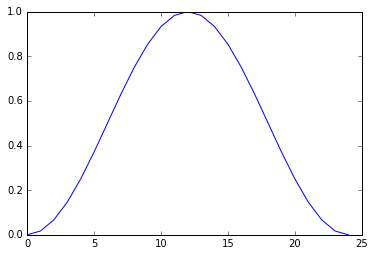

In [39]:
segment_len = 25   # WINDOWS SIZE
slide_len = 5      # WINDOWS OVERLAP

### windowing function
window_rads = np.linspace(0, np.pi, segment_len)
window = np.sin(window_rads)**2
plt.plot(window)
plt.show()

In [59]:
%matplotlib inline
filehandler = open("frequences.pkl","rb")
file_frequences = pickle.load(filehandler)
filehandler.close()

## Extracts energy features and deviation from the data
def activita(df,freq):
    result = []
    for i in range(df.shape[0]):
        f_number = i

        x_segments = []
        y_segments = []
        z_segments = []
        
        x_energies = []
        y_energies = []
        z_energies = []

        x_std = []
        y_std = []
        z_std = []
        comb_std = []

        #for i in range(df.shape[0]):
        the_data_x = df['x'].tolist()[f_number]
        the_data_y = df['y'].tolist()[f_number]
        the_data_z = df['z'].tolist()[f_number]
        mags = df['mag'].tolist()[f_number]
        Fs         =  freq[f_number] #file_frequences[df['file'].tolist()[f_number]] # 
        N_samps    = len(the_data_x)
        for start_pos in range(0, len(the_data_x), slide_len):
            end_pos = start_pos + segment_len
            
            # make a copy so changes to 'segments' doesn't modify the original ekg_data
            x_segment = np.copy(the_data_x[start_pos:end_pos])
            y_segment = np.copy(the_data_y[start_pos:end_pos])
            z_segment = np.copy(the_data_z[start_pos:end_pos])
            magnitude = np.copy(mags[start_pos:end_pos])
            # if we're at the end and we've got a truncated segment, drop it
            if len(x_segment) != segment_len:
                continue
            
            ## MULTIPLY BY WINDOWING FUNCTION TO ATTENUATE WINDOWS ENDPOINTS.
            x_segment = x_segment * window
            y_segment = y_segment * window
            z_segment = z_segment * window
            magnitude = magnitude * window

            x_segments.append(x_segment)     
            y_segments.append(y_segment)
            z_segments.append(z_segment)
            
            x_energies.append(mf.fft_energy(x_segment))
            y_energies.append(mf.fft_energy(y_segment))
            z_energies.append(mf.fft_energy(z_segment))

            stdx = np.std([np.abs(x) + np.abs(y) + np.abs(z) for x,y,z in zip(x_segment,y_segment,z_segment)])

            x_std.append(stdx)
            
            comb_std.append(stdx)

        # 
        t  = np.linspace(0,N_samps*(1/Fs),N_samps) # N_samps*T (#samples x sample period) is the signal time.


        #print (len(the_data_x)/4) -8
        a = np.arange(0,len(t),5 *(1/Fs))
        x = a[:int(len(x_energies))]
        y = a[:int(len(y_energies))]
        z = a[:int(len(z_energies))]

        fig = plt.figure(figsize=[12,7])
        ax0 = plt.subplot(411)
        ax0.plot(t,the_data_x, label='x')
        ax0.plot(t,the_data_y, label='y')
        ax0.plot(t,the_data_z, label='z')
        ax0.set_ylabel('accelerometer')
        ax0.set_xticks(np.arange(0,t[-1],1))
        
        plt.grid()
        plt.legend(loc='best', frameon=False, fontsize=8)
        ax1 = plt.subplot(412, sharex=ax0)
        ax1.plot(x,x_energies, label='x_energy')
        ax1.plot(y,y_energies, label='y_energy')
        ax1.plot(z,z_energies, label='z_energy')
        ax1.set_ylabel('energy')
        plt.grid()
        plt.legend(loc='best', frameon=False, fontsize=8)
        ax2 = plt.subplot(413, sharex=ax0)
        ax2.plot(z,x_std, label= 'x')
        ax2.set_ylabel('std magnitude')
        plt.grid()
        plt.legend(loc='best', frameon=False, fontsize=8)
        ax3 = plt.subplot(414, sharex=ax0)
        ax3.plot(z,comb_std, label= 'avg')
        #sio.savemat(df['file'].tolist()[f_number], {'x':comb_std})
        
        # inactive threshold
        mu = 0.5
        start = -1
        for i,d in enumerate(comb_std):
            dictionary = {}
            if (d >= mu) and (start < 0):
            #if (np.abs((d - mu)/sigma) > var_thd * sigma) and (start < 0):
                start = i
            elif (i == (len(comb_std)-1)):
                ax3.fill_between(z[start:i],comb_std[start:i],0,color='0.8')
                peaks = detect_peaks(comb_std[start:i], mph=mu, show=False)
                peak_values = [(comb_std[start:i][p],p) for p in peaks]
                ax3.scatter([z[start:i][k] for k in peaks], [p[0] for p in peak_values], marker='x', color='r')
                
                if len(peaks) !=0:
                    int_data = np.array(comb_std[start:i])
                    max_peak, peak_pos = max(peak_values,key=itemgetter(0))
                    dictionary['max_peak'] = max_peak
                    delta_T = z[i] - z[start]
                    activity_area = delta_T * max_peak
                    activity_ci = (np.sum(int_data) - activity_area) / float(activity_area)
                    dictionary['ci'] = activity_ci
                    dictionary['num_peaks'] = len(peaks)
                    dictionary['dt'] = delta_T
                    dictionary['act'] = int_data
                    dictionary['dt_samples'] = z[start:i]
                    result.append(dictionary)
                    
                    plt.text(start + len(int_data)/2, 0.4, len(result)-1, fontsize=8, horizontalalignment='center',
                         verticalalignment='center',transform = ax3.transAxes)
                    
            elif (d < mu) and (start >= 0):
                peaks = detect_peaks(comb_std[start:i], mph=mu, show=False)
                peak_values = [(comb_std[start:i][p],p) for p in peaks]
                ax3.scatter([z[start:i][k] for k in peaks], [comb_std[start:i][p] for p in peaks], marker='x', color='r')
                ax3.fill_between(z[start:i],comb_std[start:i],0,color='0.8')
                if len(peaks) !=0:
                    int_data = np.array(comb_std[start:i])
                    max_peak, peak_pos = max(peak_values,key=itemgetter(0))
                    dictionary['max_peak'] = max_peak
                    delta_T = z[i] - z[start]
                    activity_area = delta_T * max_peak
                    activity_ci = (np.sum(int_data) - activity_area) / float(activity_area)
                    dictionary['ci'] = activity_ci
                    dictionary['num_peaks'] = len(peaks)
                    dictionary['dt'] = delta_T
                    dictionary['act'] = int_data
                    dictionary['dt_samples'] = z[start:i]
                    result.append(dictionary)
                    plt.text(start + len(int_data)/2, 0.4, len(result)-1, fontsize=8, horizontalalignment='center',
                         verticalalignment='center',transform = ax3.transAxes)
                start = -1
            
        ax3.axhline(y=mu, color='r', marker='.')

        #combined = [i+j+k for i,j,k in zip(x_energies,y_energies,z_energies)]
        #plt.plot(z,combined, label='combined')
        ax3.set_xlabel('seconds')
        ax3.set_ylabel('std')
        plt.grid()
        
        plt.xlim(0,plt.xlim()[1])
        plt.legend(loc='best', frameon=False, fontsize=8)

        fig.suptitle('{}'.format(df['file'].tolist()[f_number] + ' {:.2f}'.format(Fs)), fontsize=21)
        fig.subplots_adjust(hspace=0.3, wspace= 0.5)
        plt.draw()


        print("Produced %d waveform segments" % len(x_segments))
    return result

In [86]:
arm_csv_dir = "../data/new_data/"
files_arm = getListOfFiles(arm_csv_dir, ".csv")
#print ">> {} CSV Files found:\n".format(len(files_arm))
#print json.dumps(files_arm)

In [17]:
datasetX, datasetY, datasetZ, mags, freq = processFiles(files,csv_dir)

In [21]:
dic = {'x'   :[x[0] for x in datasetX],
       'y'   :[y[0] for y in datasetY],
       'z'   :[z[0] for z in datasetZ],
       'mag' :[m[0] for m in mags],
       'file':[f[1] for f in datasetX],} 
arm_df = pd.DataFrame(dic, columns=['x','y','z','mag','file'])

Produced 363 waveform segments
Produced 422 waveform segments
Produced 187 waveform segments
Produced 344 waveform segments
Produced 406 waveform segments
Produced 466 waveform segments
Produced 712 waveform segments
Produced 274 waveform segments
Produced 275 waveform segments
Produced 451 waveform segments
Produced 245 waveform segments
Produced 392 waveform segments
Produced 480 waveform segments
Produced 436 waveform segments
Produced 683 waveform segments
Produced 363 waveform segments
Produced 148 waveform segments
Produced 101 waveform segments
Produced 121 waveform segments
Produced 803 waveform segments
Produced 685 waveform segments
Produced 905 waveform segments
Produced 480 waveform segments
Produced 421 waveform segments
Produced 479 waveform segments
Produced 376 waveform segments
Produced 662 waveform segments
Produced 287 waveform segments
Produced 1065 waveform segments


ValueError: Image size of 239444x474 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 275937x474 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 117577x474 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 205295x474 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 262205x474 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 294348x474 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 470121x474 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 174495x474 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 182531x474 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 278618x474 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 159430x474 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 256856x474 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 303059x474 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 259195x474 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 452714x474 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 240116x474 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 92470x474 pixels is too large. It must be less than 2^16 in each direction.

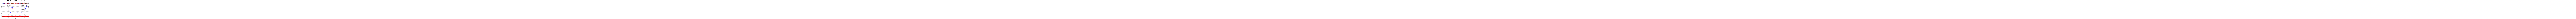

ValueError: Image size of 66020x474 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 535745x474 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 437314x474 pixels is too large. It must be less than 2^16 in each direction.

In [ ]:
res = activita(arm_df,freq)

[]

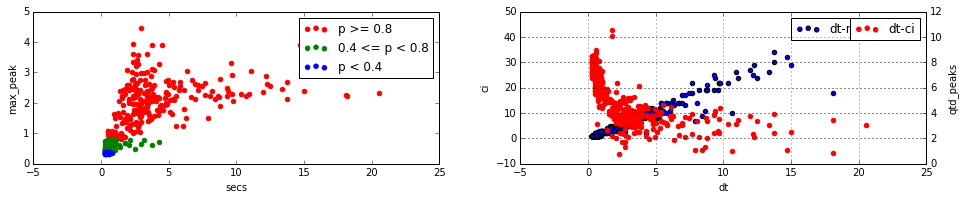

In [48]:
from mpl_toolkits.mplot3d import Axes3D
th = 0.8
roi1 = [(r['max_peak'],r['dt']) for i,r in enumerate(res) if r['max_peak'] >= th]
roi2 = [(r['max_peak'],r['dt']) for i,r in enumerate(res) if r['max_peak'] < th and r['max_peak'] >= 0.4]
roi3 = [(r['max_peak'],r['dt']) for i,r in enumerate(res) if r['max_peak'] > 0.2 and r['max_peak'] < 0.4]

roi = [roi1,roi2,roi3]

fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(221)

leg = ['p >= 0.8', '0.4 <= p < 0.8', 'p < 0.4']

colors = ['r','g','b']
for i in range(len(roi)):
    X_train = np.array([[r[1] for r in roi[i]],[r[0] for r in roi[i]]]).T
    ax.scatter(X_train[:,0],X_train[:,1], color=colors[i], label=leg[i])
ax.set_xlabel('secs')
ax.set_ylabel('max_peak')
plt.legend()

ax2 = fig.add_subplot(222)
X_train = np.array([[r['dt'] for r in res],[r['num_peaks'] for r in res]]).T
ax2.scatter(X_train[:,0],X_train[:,1], label='dt-num_peaks')
ax2.set_xlabel('dt')
ax2.set_ylabel('ci')
plt.legend()
plt.grid()

ax3 = ax2.twinx()
X_train = np.array([[r['dt'] for r in res],[r['ci'] for r in res]]).T
ax3.scatter(X_train[:,0],X_train[:,1],color='r', label='dt-ci')
ax3.set_xlabel('dt')
ax3.set_ylabel('qtd_peaks')
plt.legend()
plt.grid()
plt.plot()

Using matplotlib backend: MacOSX


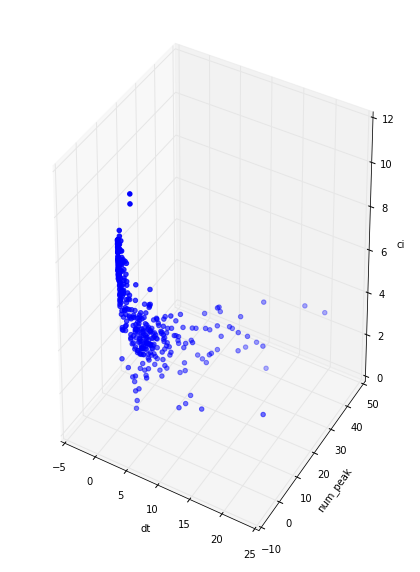

In [54]:
from mpl_toolkits.mplot3d import Axes3D 
%matplotlib

fig = plt.figure(figsize=(40,10))
ax = fig.add_subplot(121, projection='3d')

X_train = np.array([[r['dt'] for r in res],[r['num_peaks'] for r in res],[r['ci'] for r in res]]).T
ax.scatter(X_train[:,0],X_train[:,1],X_train[:,2],color='b')
ax.set_xlabel('dt')
ax.set_ylabel('num_peak')
ax.set_zlabel('ci')
plt.grid()

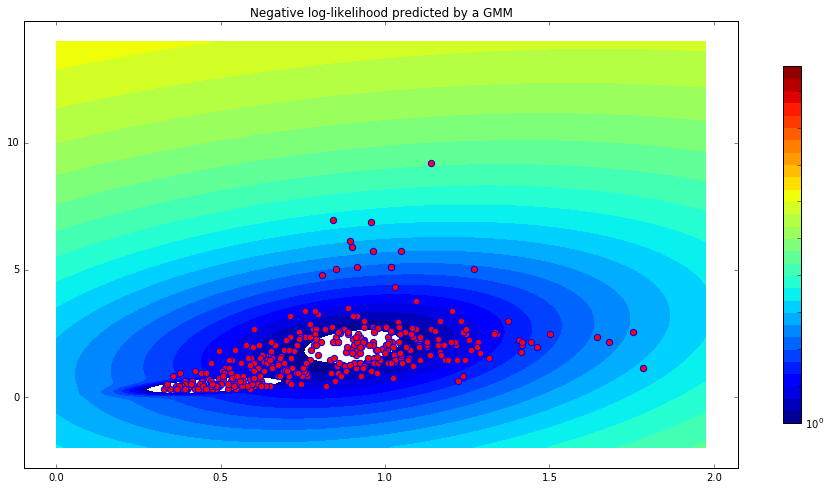

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors, ticker, cm
from matplotlib.colors import LogNorm
from sklearn import mixture
delta = 0.025
fig = plt.figure(figsize=(16,8))
# fit a Gaussian Mixture Model with two components
clf = mixture.GaussianMixture(n_components=2, covariance_type='full')
#X_train = np.array([[r['max_peak'] for r in res],[r['dt'] for r in res]]).T
X_train = np.array([[r['max_peak'] for r in res],[r['dt'] for r in res]]).T
clf.fit(X_train)

# display predicted scores by the model as a contour plot
x = np.arange(-0, 2, delta)
y = np.arange(-2, 14,delta)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)
lvls = np.logspace(0,3,30)
CS = plt.contourf(X, Y, Z, 50,cmap='jet', norm=LogNorm(),
                 levels=lvls)
CB = plt.colorbar(CS,shrink=0.8, extend='both')
plt.scatter(X_train[:, 0], X_train[:, 1],s=40, color='r',edgecolor='b')

plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
plt.show()
